✅ Found CSV at: /content/machine_learning_abstracts_2016_2025.csv


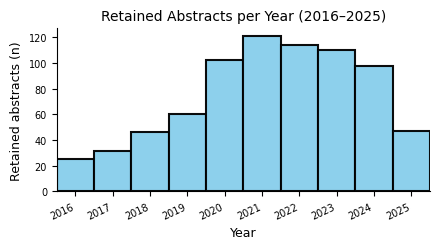

✅ Saved: /content/retained_abstracts_per_year_2016_2025.png


,year_int,n_retained
0,2016,25
1,2017,31
2,2018,46
3,2019,60
4,2020,102
5,2021,121
6,2022,114
7,2023,110
8,2024,98
9,2025,47


In [ ]:
import os, glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

TARGET_NAME = "machine_learning_abstracts_2016_2025.csv"

def find_file(root="/content", exact=TARGET_NAME):
    exact_hits = glob.glob(os.path.join(root, "**", exact), recursive=True)
    if exact_hits:
        return exact_hits[0]
    close_hits = glob.glob(os.path.join(root, "**", "machine_learning_abstracts_2016_2025*.csv"), recursive=True)
    if close_hits:
        return close_hits[0]
    return None

CSV_PATH = find_file()
if CSV_PATH is None:
    raise FileNotFoundError("❌ CSV not found under /content.")
print("✅ Found CSV at:", CSV_PATH)

df = pd.read_csv(CSV_PATH)

year_col = "year_final" if "year_final" in df.columns else "year"
df[year_col] = pd.to_numeric(df[year_col], errors="coerce")

year_counts = (
    df.dropna(subset=[year_col])
      .assign(year_int=lambda x: x[year_col].astype(int))
      .query("2016 <= year_int <= 2025")
      .groupby("year_int")
      .size()
      .reindex(range(2016, 2026), fill_value=0)
      .reset_index(name="n_retained")
)

years = year_counts["year_int"].values.astype(int)
y = year_counts["n_retained"].values.astype(int)
x = np.arange(len(years))

# --- Style like your example (skyblue fill + black edges) ---
fig, ax = plt.subplots(figsize=(4.5, 2.6))

ax.bar(
    x, y,
    width=1.0,
    color="skyblue",      # same vibe as the example
    edgecolor="black",
    linewidth=1.5,
    alpha=0.95
)

ax.set_xlim(-0.5, len(years) - 0.5)
ax.margins(x=0)

ax.set_xlabel("Year", fontsize=9)
ax.set_ylabel("Retained abstracts (n)", fontsize=9)
ax.set_title("Retained Abstracts per Year (2016–2025)", fontsize=10)

# only x & y axes (no top/right black lines)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# smaller ticks so they don't overlap
ax.tick_params(axis="both", labelsize=7)
ax.set_xticks(x)
ax.set_xticklabels([str(v) for v in years], rotation=25, ha="right")

ax.grid(False)

plt.tight_layout()
out_path = "/content/retained_abstracts_per_year_2016_2025.png"
plt.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()

print("✅ Saved:", out_path)
display(year_counts)


In [3]:
# CELL 0 — Setup
import os, json
import pandas as pd
import matplotlib.pyplot as plt

REPORT_JSON = "data_curation_report.json"
FIG_DIR = "reports/01_data_curation/figures"
os.makedirs(FIG_DIR, exist_ok=True)

with open(REPORT_JSON, "r", encoding="utf-8") as f:
    R = json.load(f)

R.keys()


dict_keys(['journal', 'years', 'source_pipeline', 'dois_total_after_union_dedup', 'papers_found_in_semantic_scholar_total_rows', 'semantic_scholar_status_counts', 'before_year_filter', 'after_year_filter', 'before_abstract_filter', 'after_abstract_filter', 'expected_journal', 'expected_doi_prefix', 'crossref_container_title_exact_match_rate', 'doi_prefix_match_rate', 'combined_journal_match_rate', 'top_venues_s2_after_curation', 'papers_per_year'])

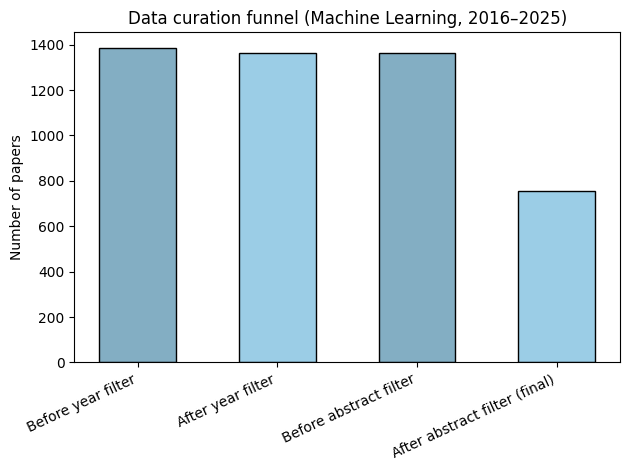

,stage,n
0,Before year filter,1385
1,After year filter,1364
2,Before abstract filter,1364
3,After abstract filter (final),754


In [9]:
# CELL 1 — Funnel (filters summary): before/after year, before/after abstract

funnel = pd.DataFrame([
    {"stage": "Before year filter", "n": R["before_year_filter"]},
    {"stage": "After year filter", "n": R["after_year_filter"]},
    {"stage": "Before abstract filter", "n": R["before_abstract_filter"]},
    {"stage": "After abstract filter (final)", "n": R["after_abstract_filter"]},
])

# Colors (image color + darker variant)
COLOR_AFTER  = "#9BCDE6"  # image-like light blue
COLOR_BEFORE = "#83AEC3"  # darker for contrast

colors = [
    COLOR_BEFORE if s.lower().startswith("before") else COLOR_AFTER
    for s in funnel["stage"]
]

plt.figure()
plt.bar(
    funnel["stage"],
    funnel["n"],
    color=colors,
    width=0.55,          # narrower bars
    edgecolor="black",
    linewidth=1.0
)
plt.xticks(rotation=25, ha="right")
plt.ylabel("Number of papers")
plt.title("Data curation funnel (Machine Learning, 2016–2025)")
plt.tight_layout()

out = os.path.join(FIG_DIR, "c1_curation_funnel.png")
plt.savefig(out, dpi=200, bbox_inches="tight")
plt.show()

funnel


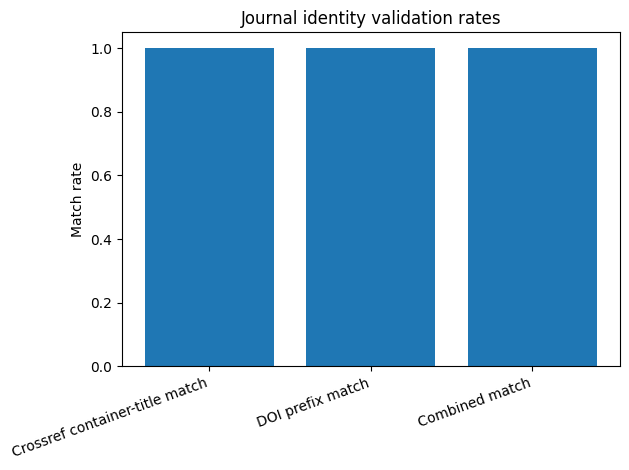

,check,rate
0,Crossref container-title match,1.0
1,DOI prefix match,1.0
2,Combined match,1.0


In [5]:
# CELL 2 — Journal identity validation rates

rates = pd.DataFrame([
    {"check": "Crossref container-title match", "rate": R["crossref_container_title_exact_match_rate"]},
    {"check": "DOI prefix match", "rate": R["doi_prefix_match_rate"]},
    {"check": "Combined match", "rate": R["combined_journal_match_rate"]},
])

plt.figure()
plt.bar(rates["check"], rates["rate"])
plt.ylim(0, 1.05)
plt.xticks(rotation=20, ha="right")
plt.ylabel("Match rate")
plt.title("Journal identity validation rates")
plt.tight_layout()

out = os.path.join(FIG_DIR, "c2_journal_validation_rates.png")
plt.savefig(out, dpi=200, bbox_inches="tight")
plt.show()

rates


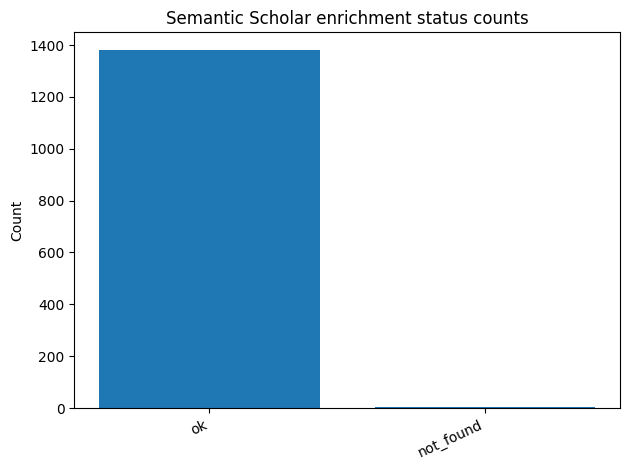

,count
ok,1380
not_found,5


In [8]:
# CELL 5 — (Optional) Status counts (if present)

if "semantic_scholar_status_counts" in R and R["semantic_scholar_status_counts"]:
    status = pd.Series(R["semantic_scholar_status_counts"]).sort_values(ascending=False)

    plt.figure()
    plt.bar(status.index, status.values)
    plt.xticks(rotation=25, ha="right")
    plt.ylabel("Count")
    plt.title("Semantic Scholar enrichment status counts")
    plt.tight_layout()

    out = os.path.join(FIG_DIR, "c5_s2_status_counts.png")
    plt.savefig(out, dpi=200, bbox_inches="tight")
    plt.show()

    display(status.to_frame("count"))
else:
    print("No semantic_scholar_status_counts found in report (or empty).")


              year  alignment_score_topk_mean
count   754.000000                 754.000000
mean   2021.274536                   0.351379
std       2.307149                   0.071186
min    2016.000000                   0.126197
25%    2020.000000                   0.305338
50%    2021.000000                   0.350573
75%    2023.000000                   0.402525
max    2025.000000                   0.627483


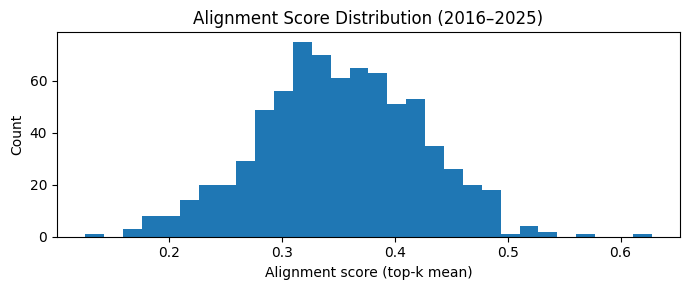

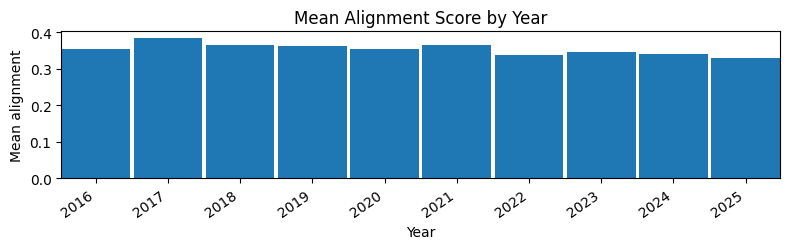

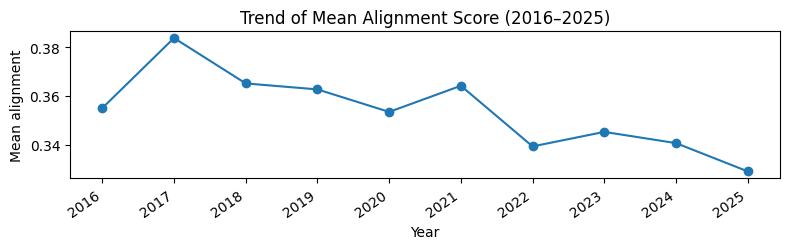

In [ ]:
# ============================================================
# CELL — Visualize alignment_score_topk_mean from scored CSV
# ============================================================

import os
import pandas as pd
import matplotlib.pyplot as plt

SCORED_PATH = "machine_learning_scored_2016_2025.csv"

if not os.path.exists(SCORED_PATH):
    raise FileNotFoundError(f"Not found: {SCORED_PATH}")

df_sc = pd.read_csv(SCORED_PATH)

# Ensure numeric
df_sc["year"] = pd.to_numeric(df_sc["year"], errors="coerce").astype(int)
df_sc["alignment_score_topk_mean"] = pd.to_numeric(df_sc["alignment_score_topk_mean"], errors="coerce")

print(df_sc[["year","alignment_score_topk_mean"]].describe())

# ---------------------------
# 1) Histogram: score distribution
# ---------------------------
plt.figure(figsize=(7, 3))
plt.hist(df_sc["alignment_score_topk_mean"].dropna(), bins=30)
plt.xlabel("Alignment score (top-k mean)")
plt.ylabel("Count")
plt.title("Alignment Score Distribution (2016–2025)")
plt.tight_layout()
plt.show()

# ---------------------------
# 2) Yearly mean (bar chart)
# ---------------------------
yearly = df_sc.groupby("year")["alignment_score_topk_mean"].mean().reset_index()

plt.figure(figsize=(8, 2.6))  # long & thin
plt.bar(yearly["year"].astype(str), yearly["alignment_score_topk_mean"], width=0.95)
plt.xlabel("Year")
plt.ylabel("Mean alignment")
plt.title("Mean Alignment Score by Year")
plt.xticks(rotation=35, ha="right")
plt.margins(x=0)  # reduce gaps at edges
plt.tight_layout()
plt.show()

# ---------------------------
# 3) Yearly mean (line chart)
# ---------------------------
plt.figure(figsize=(8, 2.6))
plt.plot(yearly["year"], yearly["alignment_score_topk_mean"], marker="o")
plt.xlabel("Year")
plt.ylabel("Mean alignment")
plt.title("Trend of Mean Alignment Score (2016–2025)")
plt.xticks(yearly["year"])
plt.xticks(rotation=35, ha="right")
plt.tight_layout()
plt.show()


In [2]:
# ============================================================
# CELL — Load overall_purity_summary.csv + export LaTeX table
# ============================================================

import os
import pandas as pd

# If you uploaded the file to notebook root, this path works:
CSV_PATH = "./overall_purity_summary.csv"

# If it is inside a folder, update it accordingly, e.g.:
# CSV_PATH = "./outputs_p7/report_findings/tables/overall_purity_summary.csv"

if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"File not found: {CSV_PATH}. Check the Files panel path/name.")

df = pd.read_csv(CSV_PATH)

# Show nicely in Colab output
display(df)

# Create LaTeX table code
latex = df.to_latex(
    index=False,
    float_format="%.3f",
    caption="Overall journal-purity evidence for the scored dataset (Machine Learning, 2016--2025).",
    label="tab:journal_purity_overall"
)

print(latex)

# Save as .tex for easy copy-paste into the report
OUT_TEX = "./table_journal_purity_overall.tex"
with open(OUT_TEX, "w", encoding="utf-8") as f:
    f.write(latex)

print("✅ Saved LaTeX table to:", OUT_TEX)


,n_rows_scored,doi_prefix_match_rate,crossref_container_title_match_rate,venue_name_match_rate_informational,combined_match_rate
0,754,1.0,1.0,0.0,1.0


\begin{table}
\caption{Overall journal-purity evidence for the scored dataset (Machine Learning, 2016--2025).}
\label{tab:journal_purity_overall}
\begin{tabular}{rrrrr}
\toprule
n_rows_scored & doi_prefix_match_rate & crossref_container_title_match_rate & venue_name_match_rate_informational & combined_match_rate \\
\midrule
754 & 1.000 & 1.000 & 0.000 & 1.000 \\
\bottomrule
\end{tabular}
\end{table}

✅ Saved LaTeX table to: ./table_journal_purity_overall.tex
